In [7]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

df = pd.read_csv(r'c:\Users\Gur Levy\Desktop\PORTFOLIO\DE_PORTFOLIO\combined_data.csv')

In [8]:
df = df[df['Player'] == 'K. De Bruyne']
print(df)
print(df['Accurate passes'].dropna().astype(int).head(1000).to_list())

             Player                                Match  \
65681  K. De Bruyne                Croatia - Belgium 0:0   
65682  K. De Bruyne                Belgium - Morocco 0:2   
65683  K. De Bruyne                 Belgium - Canada 1:0   
65684  K. De Bruyne                  Belgium - Egypt 1:2   
65685  K. De Bruyne      Manchester City - Brentford 1:2   
...             ...                                  ...   
66079  K. De Bruyne     Belgium - Bosnia-Herzegovina 3:1   
66080  K. De Bruyne                 Köln - Wolfsburg 1:1   
66081  K. De Bruyne  Wolfsburg - Eintracht Frankfurt 2:1   
66082  K. De Bruyne  Stuttgarter Kickers - Wolfsburg 1:4   
66083  K. De Bruyne   Wolfsburg - Bayern München (P) 1:1   

                    Competition        Date         Position  Minutes played  \
65681          World. World Cup  2022-12-01              AMF              98   
65682          World. World Cup  2022-11-27  AMF, RAMF, RDMF              99   
65683          World. World Cup  2022-1

In [9]:
df = df[df['Competition'] == 'England. Premier League']

In [10]:
df['Total_Accurate_Passes'] = df['Accurate passes'] + df['Accurate back passes'] + df['Accurate crosses'] + df['Accurate forward passes'] + df['Accurate long passes'] + df['Accurate passes to GK'] + df['Accurate passes to final third'] + df['Accurate passes to penalty area'] + df['Accurate through passes']
df.to_csv('midfielders_data.csv')

In [11]:
from kneed import KneeLocator


Elbow point at: 191


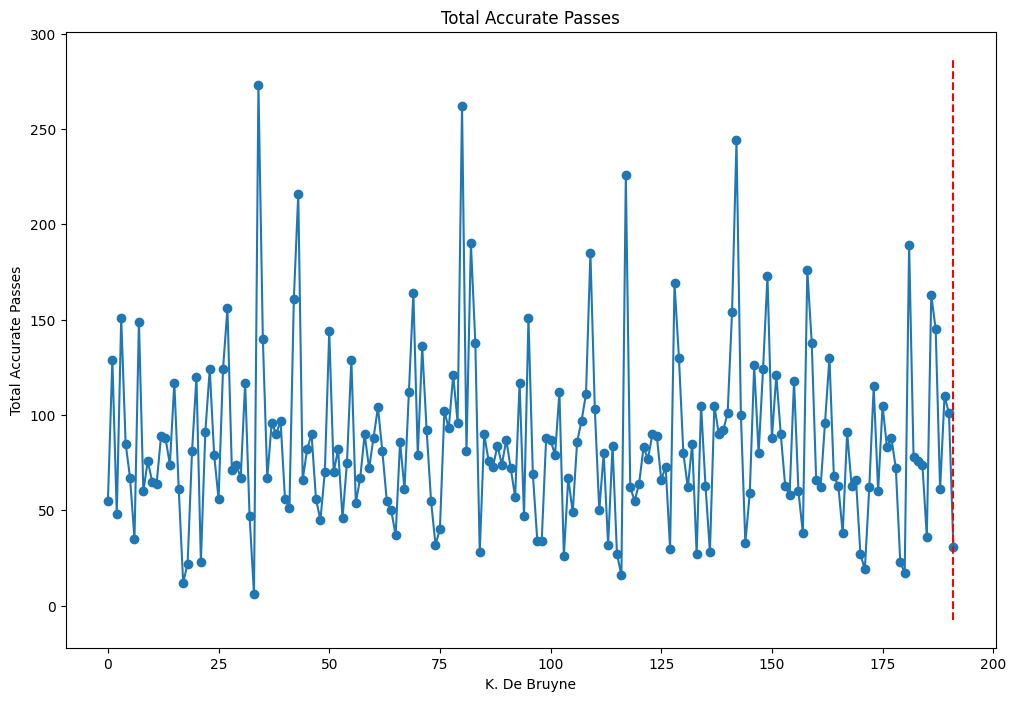

191


In [12]:

X = df[['Accurate passes', 'Accurate back passes', 'Accurate crosses', 'Accurate forward passes', 'Accurate long passes', 'Accurate passes to final third', 'Accurate passes to penalty area', 'Accurate through passes']]
Y = df['Total_Accurate_Passes']
passes_per_match = df.groupby('Match')['Total_Accurate_Passes'].sum().reset_index()
passes_per_match = passes_per_match.sort_values('Match')
x = range(len(passes_per_match))
y = passes_per_match['Total_Accurate_Passes'].values
# Finding the elbow point
kneedle = KneeLocator(x, y, curve='convex', direction='increasing', S=0.1)
elbow_point = kneedle.elbow

print(f"Elbow point at: {elbow_point}")
# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x, y, marker='o', linestyle='-')
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',color = 'red')
plt.xlabel('K. De Bruyne')
plt.ylabel('Total Accurate Passes')
plt.title('Total Accurate Passes')

plt.show()

print(elbow_point)

In [15]:
X = df[['Total_Accurate_Passes',
        'Accurate passes',
        'Accurate crosses', 
        'Accurate forward passes', 
        'Accurate long passes', 
        'Accurate passes to final third', 
        'Accurate passes to penalty area', 
        'Accurate through passes', 
]]
# Drop rows with missing values in any selected variable or the target
data_cleaned = X.dropna(axis=0, how='any')
y_cleaned = data_cleaned['Total_Accurate_Passes']
y_log_cleaned = np.log(data_cleaned['Total_Accurate_Passes']+1) #normalize dist +1 to avoind log 0
X_cleaned = data_cleaned.drop(columns=['Total_Accurate_Passes'])

In [16]:
X_encoded = pd.get_dummies(X_cleaned, columns=['Accurate passes',
        'Accurate crosses', 
        'Accurate forward passes', 
        'Accurate long passes', 
        'Accurate passes to final third', 
        'Accurate passes to penalty area', 
        'Accurate through passes'], drop_first=True).astype(int) #drop to avoid dummy trap

In [17]:
# Drop variables with 0 variability (no information) or high correlation (multicollinearity)

# VarianceThreshold with a threshold of 0 (default) to remove 0 variance columns
selector = VarianceThreshold()
X_encoded_var_filtered = selector.fit_transform(X_encoded)
# Get the columns after variance thresholding
X_encoded_var_filtered = X_encoded.iloc[:, selector.get_support(indices=True)]

In [18]:
# Calculate the correlation matrix (absolute value - we don't care about direction of correlation)
corr_matrix = X_encoded_var_filtered.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to keep track of columns to drop
to_drop = []

# Iterate over the columns of the upper triangle
for column in upper_tri.columns:
    for row in upper_tri.index:
        # Check if the correlation is above the threshold and the column hasn't been considered yet
        if upper_tri.loc[row, column] > 0.9 and column not in to_drop and row not in to_drop:
            to_drop.append(column)
            break  # Break the loop once a column is marked for dropping

# 'to_drop' contains columns where only one of each highly correlated pair is considered for dropping

In [19]:
# Drop highly correlated features 
X_encoded_final = X_encoded_var_filtered.drop(columns=to_drop)

In [20]:
# Standardise features to help with interpretation 

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_encoded_final)

# Apply transform to both the training set and the test set
X_train_scaled = pd.DataFrame(scaler.transform(X_encoded_final), columns=X_encoded_final.columns, index=X_encoded_final.index)

In [21]:
# Adding a constant for the intercept
X_encoded_with_const = sm.add_constant(X_train_scaled)

In [22]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.OLS(y_cleaned, X_encoded_with_const ).fit()

# Displaying the regression results
print(model.summary())

C:\Users\Gur Levy\AppData\Local\Temp\ipykernel_18992\532582492.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                              OLS Regression Results                             
Dep. Variable:     Total_Accurate_Passes   R-squared:                       0.998
Model:                               OLS   Adj. R-squared:                  0.994
Method:                    Least Squares   F-statistic:                     251.2
Date:                   Thu, 14 Nov 2024   Prob (F-statistic):           2.88e-78
Time:                           08:19:27   Log-Likelihood:                -410.38
No. Observations:                    221   AIC:                             1099.
Df Residuals:                         82   BIC:                             1571.
Df Model:                            138                                         
Covariance Type:               nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

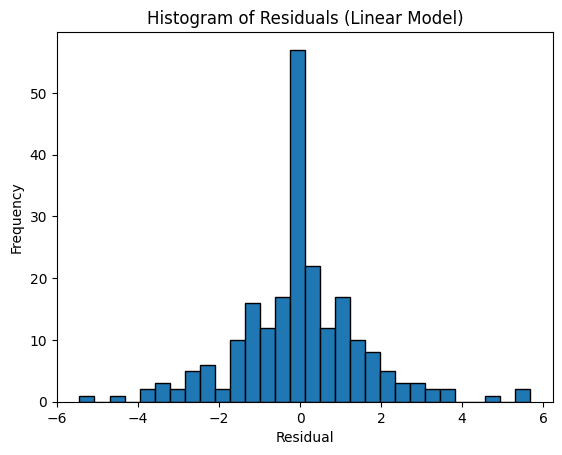

In [23]:
# Plotting histogram of residuals
residuals = model.resid
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Linear Model)')
plt.show()

In [24]:
# extract and plot regression coefficients 
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

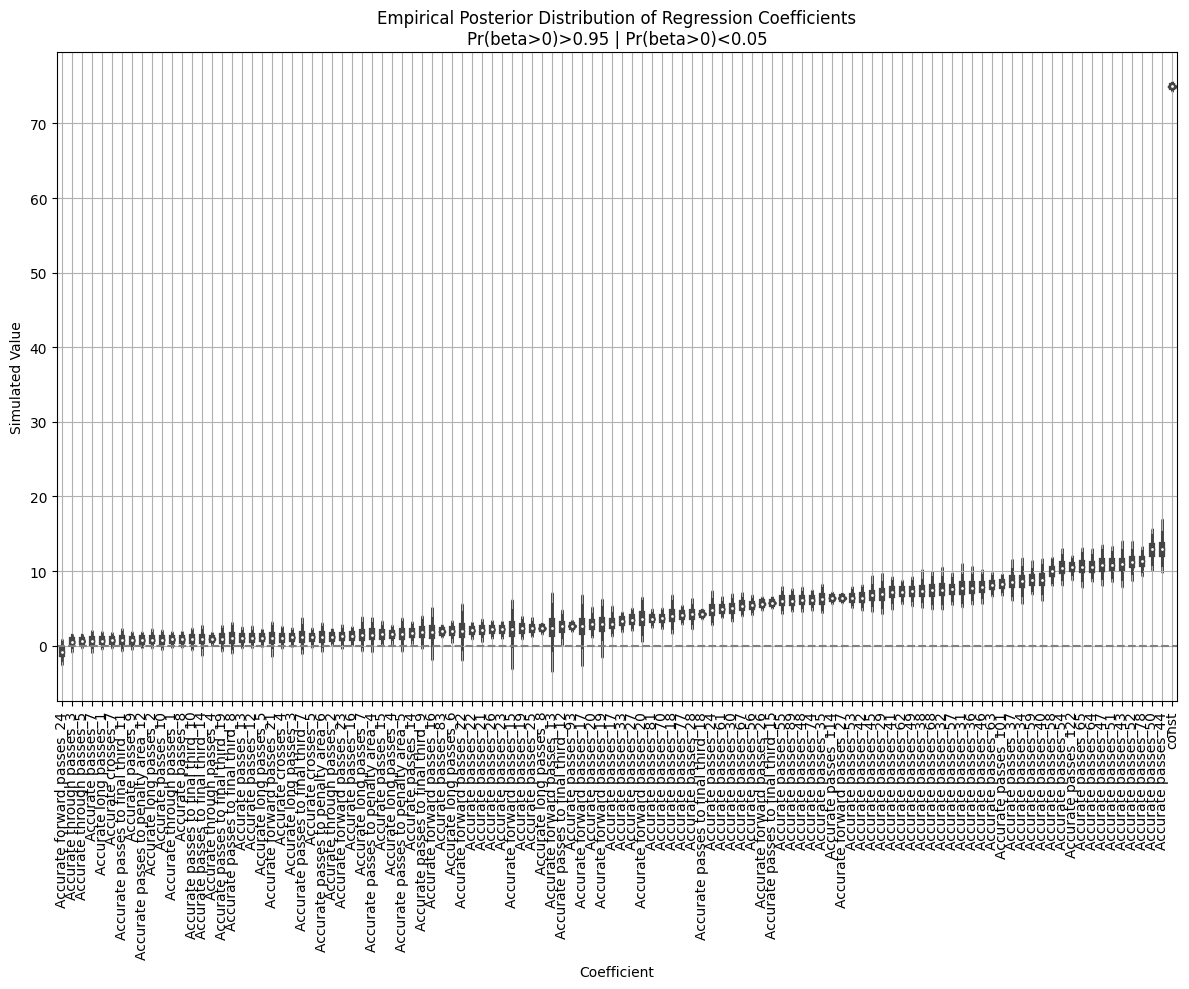

In [25]:
# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')

# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [26]:
# Initialize an array to store predictions from each simulation
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

In [27]:
# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_rate = np.dot(X_encoded_with_const, beta_simulation)
    predicted_counts[i] = np.random.normal(predicted_rate,np.sqrt(model.scale))

In [28]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)


# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

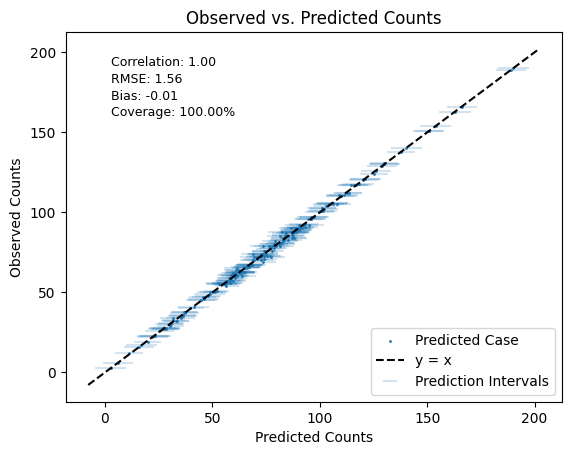

In [ ]:
# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Predicted Case')
errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  
text_y_start = max_val - (max_val - min_val) * 0.05  
line_height = (max_val - min_val) * 0.05  

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Counts')
plt.xlabel('Predicted Counts')
plt.ylabel('Observed Counts')
plt.show()


In [ ]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.OLS(y_log_cleaned, X_encoded_with_const ).fit()

# Displaying the regression results
print(model.summary())

C:\Users\Gur Levy\AppData\Local\Temp\ipykernel_3248\598896821.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                              OLS Regression Results                             
Dep. Variable:     Total_Accurate_Passes   R-squared:                       0.998
Model:                               OLS   Adj. R-squared:                  0.995
Method:                    Least Squares   F-statistic:                     295.6
Date:                   Tue, 02 Apr 2024   Prob (F-statistic):           3.82e-81
Time:                           09:14:16   Log-Likelihood:                 517.18
No. Observations:                    221   AIC:                            -756.4
Df Residuals:                         82   BIC:                            -284.0
Df Model:                            138                                         
Covariance Type:               nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

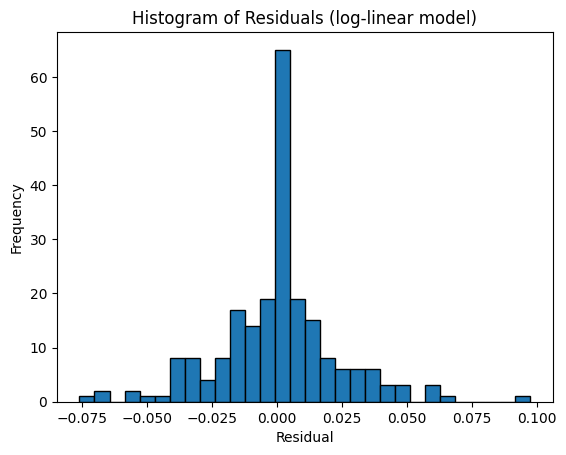

In [ ]:
# Plotting histogram of residuals
residuals = model.resid
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (log-linear model)')
plt.show()

In [ ]:
# extract and plot regression coefficients 
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

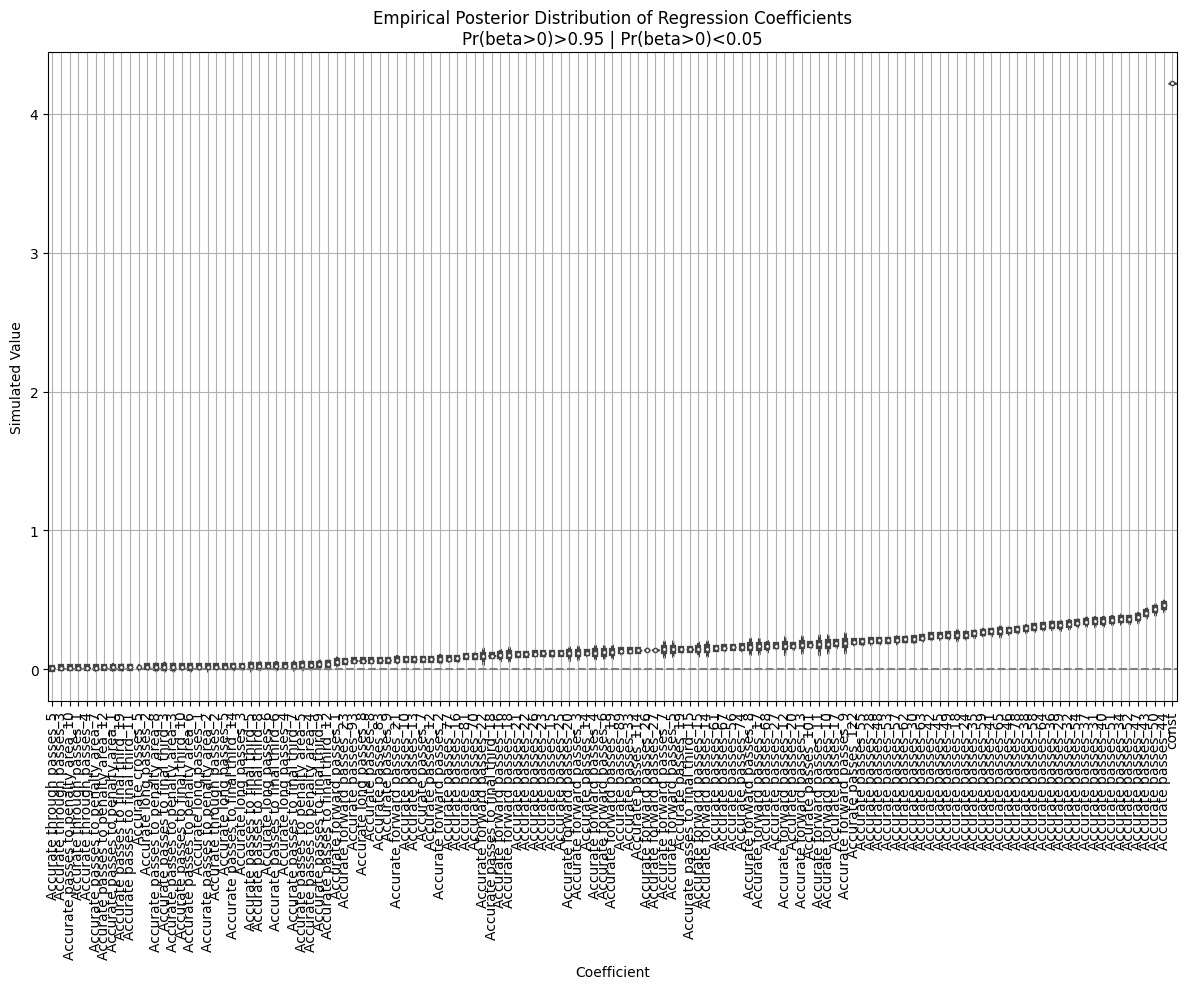

In [ ]:
# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')


# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [ ]:
# Initialize an array to store predictions from each simulation
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

In [ ]:
# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_log_rate = np.dot(X_encoded_with_const, beta_simulation)
    # Simulate from the posterior-predictive distirbution 
    # If we do nothing to `rate`, this will spit out an error because some rates will be `negativ
    predicted_counts[i] = np.exp(np.random.normal(predicted_log_rate,np.sqrt(model.scale)))

In [ ]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

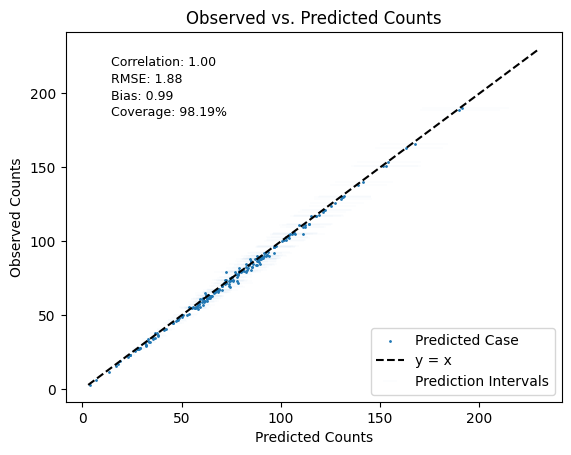

In [ ]:
# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Predicted Case')
errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.01, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Counts')
plt.xlabel('Predicted Counts')
plt.ylabel('Observed Counts')
plt.show()

In [ ]:
from statsmodels.api import GLM, Poisson

In [ ]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.GLM(y_cleaned, X_encoded_with_const, family=sm.families.Poisson()).fit()

# Displaying the regression results
print(model.summary())

C:\Users\Gur Levy\AppData\Local\Temp\ipykernel_3248\453724424.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                   Generalized Linear Model Regression Results                   
Dep. Variable:     Total_Accurate_Passes   No. Observations:                  221
Model:                               GLM   Df Residuals:                       82
Model Family:                    Poisson   Df Model:                          138
Link Function:                       Log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -671.77
Date:                   Tue, 02 Apr 2024   Deviance:                       7.8186
Time:                           09:14:34   Pearson chi2:                     7.83
No. Iterations:                      100   Pseudo R-squ. (CS):              1.000
Covariance Type:               nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

In [ ]:
# extract and plot regression coefficients 
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

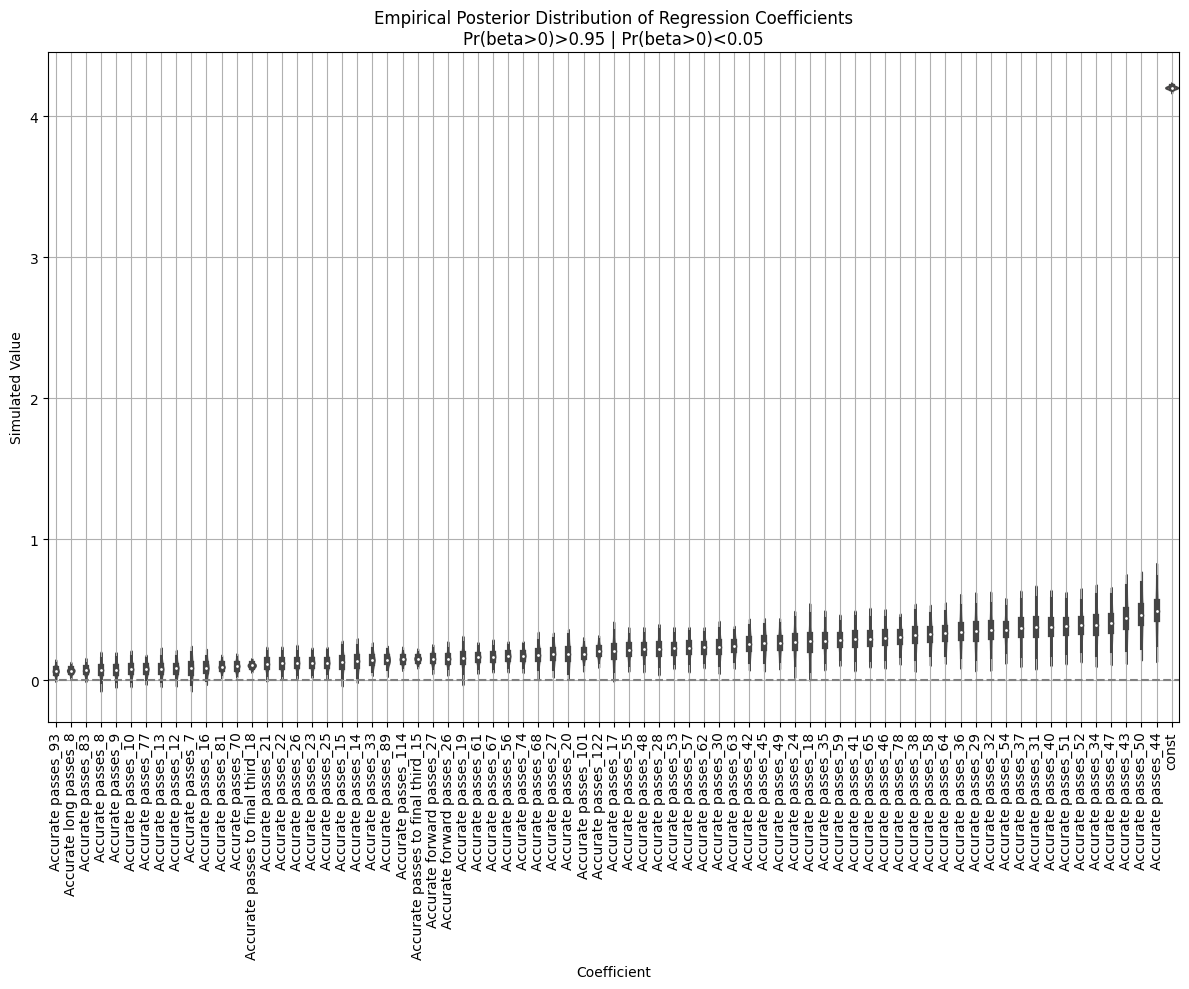

In [ ]:
# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')


# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [ ]:
# Initialize an array to store predictions from each simulation
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

In [ ]:
# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_rate = np.exp(np.dot(X_encoded_with_const, beta_simulation))
    predicted_counts[i] = np.random.poisson(predicted_rate)

In [ ]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)


# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

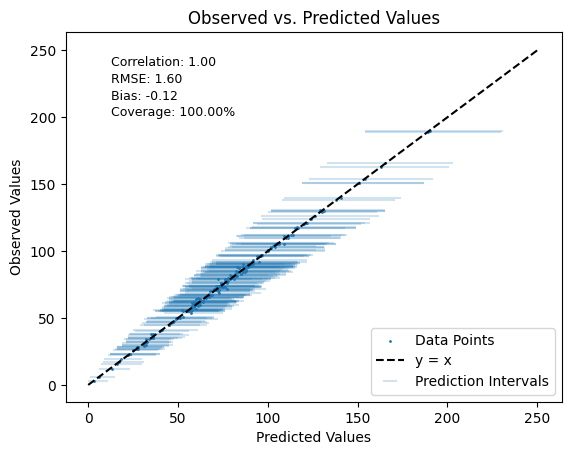

In [ ]:
# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Data Points')
errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.show()
